In [16]:
'''An example to show how to set up an pommerman game programmatically'''
import time
import pommerman
from pommerman import agents
from pommerman import constants as c
from pommerman.configs import ffa_v0_fast_env
from pommerman.envs.v0 import Pomme
from pommerman.characters import Bomber
from pommerman import utility
from pommerman import forward_model
from pommerman import constants

# Notebook 6.3
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ReinforceModel(forward_model.ForwardModel):
    def __init__(self):
        super().__init__()
    
    @staticmethod
    def get_rewards(agents, game_type, step_count, max_steps):

        def any_lst_equal(lst, values):
            '''Checks if list are equal'''
            return any([lst == v for v in values])

        alive_agents = [num for num, agent in enumerate(agents) \
                        if agent.is_alive]
        if game_type == constants.GameType.FFA:
            if len(alive_agents) == 1:
                # An agent won. Give them +1, others -1.
                return [2 * int(agent.is_alive) - 1 for agent in agents]
            elif step_count >= max_steps:
                # Game is over from time. Everyone gets -1.
                return [-1] * 4
            else:
                # Game running: 0 for alive, -1 for dead.
                
                return [int(agent.is_alive) - 1 for agent in agents]


class NewAgent(agents.BaseAgent):
    """The Random Agent that returns random actions given an action_space."""

    def __init__(self, Character=Bomber, *args, **kwargs):
        super(NewAgent,self).__init__(Character,*args, **kwargs)
        self.seq = [c.Action.Right, c.Action.Up, c.Action.Left, c.Action.Down]
        self.index = 0
    
    def act(self, obs, action_space):
        if self.index == 4:
            self.index = 0
        action = self.seq[self.index]
        self.index += 1
        return 0
    
# Print all possible environments in the Pommerman registry
print(pommerman.REGISTRY)

# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])

# Create a set of agents (exactly four)
agent_list = [
    NewAgent(config["agent"](0, config["game_type"])),
    agents.SimpleAgent(config["agent"](1, config["game_type"])),
    agents.SimpleAgent(config["agent"](2, config["game_type"])),
    agents.RandomAgent(config["agent"](3, config["game_type"])),
    # agents.DockerAgent("pommerman/simple-agent", port=12345),
]

env.set_agents(agent_list)
env.set_training_agent(0) #<- Does not call act method on training agents in env.act
env.model = ReinforceModel()
env.set_init_game_state(None)

# Run the episodes just like OpenAI Gym
#for i_episode in range(1):
#    state = env.reset()
#    done = False
#    while not done:  
#        actions = env.act(state)
#        state, reward, done, info = env.step(actions)

        #Update


#    print('Episode {} finished'.format(i_episode))
#    print(info)
#time.sleep(2)
#env.close()

    

['PommeFFACompetition-v0', 'PommeFFACompetitionFast-v0', 'PommeFFAFast-v0', 'PommeFFA-v1', 'PommeRadio-v2', 'PommeTeamCompetition-v0', 'PommeTeamCompetitionFast-v0', 'PommeTeamCompetition-v1', 'PommeTeam-v0', 'PommeTeamFast-v0']


## Notebook 6.3 Network and Train

In [18]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.ffn = nn.Sequential(
            nn.Linear(n_inputs, n_hidden),
            nn.ReLU(),
            nn.Dropout(0.25),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(0.25),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(0.25),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_outputs),
        )
        
        self.ffn.apply(self.init_weights)
        
        #self.hidden = nn.Linear(n_inputs, n_hidden)
        #self.hidden2 = nn.Linear(n_hidden, n_hidden)
        #self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = flatten_state(x)
        #print(x)
        #x = self.hidden(x)
        #x = F.relu(x)
        #x = F.relu(self.hidden2(x))
        #x = self.out(x)
        
        x = self.ffn(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))
    
    def init_weights(m, *args):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
    
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

# Example:
# def forward(self, x):
#     x = flatten_state(x)
# where x is np.atleast1d(S[0])

# Flattens a state s on the form list<dict> where each dict contains information of a state
def flatten_state(s):
    #print("\n Flatten: ",s)
    return torch.from_numpy(np.array([flatten_state_aux(x) for x in s])).float()

def flatten_state_aux(s):
    # Lists
    #print("\n Augs: ",s)
    alive = [1 if x in s['alive'] else 0 for x in range(10,14)]
    #print(alive)
    board = s['board']
    bomb_blast_strength = s['bomb_blast_strength']
    bomb_life = s['bomb_life']
    # Tuples
    position = s['position']
    # Ints
    blast_strength = s['blast_strength']
    can_kick = s['can_kick']
    ammo = s['ammo']
    # Enums
    teammate = s['teammate'] #9 for FFA
    enemies = s['enemies'] #11,12,13 for FFA and training agent id = 0
    
    a = np.append(np.array(alive),np.array(board).flatten())
    a = np.append(a,np.array(bomb_blast_strength).flatten())
    a = np.append(a,np.array(bomb_life).flatten())
    a = np.append(a,position[0])
    a = np.append(a,position[1])
    a = np.append(a,blast_strength)
    a = np.append(a,can_kick)
    a = np.append(a,ammo)
    # Commented out as we get size 376 but expected 372. I assume we calculated wrong.
    # Makes sense to ignore these imo
    #a = np.append(a,teammate.value)
    #a = np.append(a,[e.value for e in enemies])
    #print(np.shape(a))
    return a.astype(float)
    

# training settings
n_inputs = 372
n_hidden = 500
n_outputs = env.action_space.n

num_episodes = 100
#rollout_limit = env.spec.timestep_limit # max rollout length
discount_factor = 0.9 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 25 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        done = False
        #policy.train()
        while not done:
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(np.atleast_1d(s[0]))
            a = (np.cumsum(a_prob.numpy()) > np.random.rand()).argmax() # sample action
            
            actions = env.act(s)
            actions.insert(0,a)
            
            #print(actions)
            
            s1, r, done, _ = env.step(actions)
            #print(r)
            rollout.append((s[0], a, r[0]))
            #print("\n\nrollout:",rollout,"\n\n")
            s = s1
        # prepare batch
        print('done with episode:',i)
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy([s[0] for s in states]).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        #policy.eval()
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(1):
                s = env.reset()
                reward = 0
                done = False
                while not done:
                    #env.render()
                    with torch.no_grad():
                        probs = policy(np.atleast_1d(s[0]))
                        a = probs.argmax().item()
                        print(probs, "max actions: ", a,probs.argmax())
                        
                    actions = env.act(s)
                    actions.insert(0,a)
                    
                    s, r, done, _ = env.step(actions)
                    reward += r[0]
                validation_rewards.append(reward)
                #env.render(close=True)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
            time.sleep(2)
    env.close()
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training
done with episode: 0
done with episode: 1
done with episode: 2
done with episode: 3
done with episode: 4
done with episode: 5
done with episode: 6
done with episode: 7
done with episode: 8
done with episode: 9
done with episode: 10
done with episode: 11
done with episode: 12
done with episode: 13
done with episode: 14
done with episode: 15
done with episode: 16
done with episode: 17
done with episode: 18
done with episode: 19
done with episode: 20
done with episode: 21
done with episode: 22
done with episode: 23
done with episode: 24
tensor([[0.0007, 0.9663, 0.0002, 0.0326, 0.0001, 0.0001]]) max actions:  1 tensor(1)
tensor([[1.5936e-04, 9.9309e-01, 1.0034e-04, 6.6088e-03, 3.2239e-05, 7.9438e-06]]) max actions:  1 tensor(1)
tensor([[2.7319e-06, 9.9818e-01, 6.2623e-07, 1.8190e-03, 4.0576e-07, 1.2878e-07]]) max actions:  1 tensor(1)
tensor([[1.7943e-05, 9.9382e-01, 5.4162e-06, 6.1520e-03, 1.5555e-06, 2.7463e-07]]) max actions:  1 tensor(1)
tensor([[6.7916e-06, 9.9806e-01, 

tensor([[7.8580e-06, 9.9775e-01, 2.3553e-05, 2.2146e-03, 3.8157e-06, 1.6733e-06]]) max actions:  1 tensor(1)
tensor([[1.9117e-06, 9.9894e-01, 2.2471e-06, 1.0494e-03, 2.7635e-06, 3.6876e-07]]) max actions:  1 tensor(1)
tensor([[3.1682e-06, 9.9907e-01, 2.7908e-06, 9.2629e-04, 5.8815e-07, 1.8130e-07]]) max actions:  1 tensor(1)
tensor([[2.4701e-05, 9.9493e-01, 1.6340e-05, 5.0190e-03, 5.4628e-06, 1.2291e-06]]) max actions:  1 tensor(1)
tensor([[2.7490e-05, 9.9508e-01, 9.9695e-06, 4.8753e-03, 5.9070e-06, 6.7050e-07]]) max actions:  1 tensor(1)
tensor([[6.2770e-06, 9.9779e-01, 7.8947e-06, 2.1936e-03, 3.7275e-06, 8.5997e-07]]) max actions:  1 tensor(1)
tensor([[4.3837e-06, 9.9950e-01, 1.1932e-06, 4.8942e-04, 8.2668e-07, 6.1191e-08]]) max actions:  1 tensor(1)
tensor([[4.7055e-06, 9.9794e-01, 1.9710e-06, 2.0520e-03, 8.5348e-07, 1.3861e-07]]) max actions:  1 tensor(1)
tensor([[9.6027e-05, 9.8783e-01, 1.5230e-04, 1.1886e-02, 2.2448e-05, 9.5669e-06]]) max actions:  1 tensor(1)
tensor([[1.1427e-04

tensor([[1.9253e-10, 1.0000e+00, 1.2461e-10, 7.0989e-07, 2.2131e-11, 1.5646e-14]]) max actions:  1 tensor(1)
tensor([[9.6175e-12, 1.0000e+00, 1.0890e-12, 2.4732e-08, 1.5326e-14, 2.9280e-17]]) max actions:  1 tensor(1)
tensor([[9.2803e-13, 1.0000e+00, 3.5602e-13, 3.9867e-08, 8.9093e-15, 2.5961e-16]]) max actions:  1 tensor(1)
tensor([[1.3606e-10, 1.0000e+00, 1.5338e-11, 1.0120e-06, 1.2242e-12, 5.5953e-14]]) max actions:  1 tensor(1)
tensor([[3.7475e-10, 9.9999e-01, 9.8995e-10, 6.3433e-06, 1.6084e-10, 8.3654e-13]]) max actions:  1 tensor(1)
tensor([[7.6124e-11, 1.0000e+00, 2.5787e-11, 1.2680e-06, 2.3994e-12, 1.2152e-14]]) max actions:  1 tensor(1)
tensor([[4.4698e-13, 1.0000e+00, 1.5422e-13, 2.4838e-08, 5.4704e-15, 1.7744e-16]]) max actions:  1 tensor(1)
tensor([[5.3880e-14, 1.0000e+00, 1.8201e-13, 5.2914e-09, 1.1463e-15, 1.4944e-17]]) max actions:  1 tensor(1)
tensor([[5.3226e-13, 1.0000e+00, 1.4243e-12, 5.1014e-08, 3.7462e-15, 3.2390e-17]]) max actions:  1 tensor(1)
tensor([[2.7231e-10

tensor([[1.8768e-10, 1.0000e+00, 3.7432e-10, 1.1817e-06, 6.1233e-12, 4.8219e-13]]) max actions:  1 tensor(1)
tensor([[2.0888e-08, 1.0000e+00, 1.0051e-08, 4.1931e-06, 1.1911e-09, 1.5058e-11]]) max actions:  1 tensor(1)
tensor([[1.8769e-07, 9.9992e-01, 8.0598e-08, 7.6029e-05, 5.2858e-09, 7.9806e-10]]) max actions:  1 tensor(1)
tensor([[7.3138e-08, 9.9995e-01, 5.5089e-09, 4.5638e-05, 7.2907e-10, 3.0018e-11]]) max actions:  1 tensor(1)
tensor([[1.6868e-09, 1.0000e+00, 1.3101e-08, 2.0899e-06, 3.8229e-10, 4.5063e-12]]) max actions:  1 tensor(1)
tensor([[2.3296e-08, 9.9999e-01, 1.8643e-08, 7.6173e-06, 4.7461e-09, 2.7762e-10]]) max actions:  1 tensor(1)
tensor([[9.8052e-07, 9.9988e-01, 1.3607e-06, 1.1826e-04, 9.0439e-08, 1.2143e-08]]) max actions:  1 tensor(1)
tensor([[3.8587e-10, 9.9999e-01, 8.9510e-10, 1.1732e-05, 1.1717e-10, 5.6234e-13]]) max actions:  1 tensor(1)
tensor([[8.2815e-10, 9.9999e-01, 1.9678e-09, 6.9730e-06, 7.9973e-11, 1.5191e-11]]) max actions:  1 tensor(1)
tensor([[1.3201e-09

done with episode: 50
done with episode: 51
done with episode: 52
done with episode: 53
done with episode: 54
done with episode: 55
done with episode: 56
done with episode: 57
done with episode: 58
done with episode: 59
done with episode: 60
done with episode: 61
done with episode: 62
done with episode: 63
done with episode: 64
done with episode: 65
done with episode: 66
done with episode: 67
done with episode: 68
done with episode: 69
done with episode: 70
done with episode: 71
done with episode: 72
done with episode: 73
done with episode: 74
tensor([[5.1654e-11, 1.0000e+00, 1.8651e-10, 1.5301e-07, 6.3922e-12, 3.3717e-13]]) max actions:  1 tensor(1)
tensor([[2.8407e-12, 1.0000e+00, 8.2518e-12, 8.1138e-08, 5.9360e-14, 7.1233e-17]]) max actions:  1 tensor(1)
tensor([[2.6350e-10, 1.0000e+00, 1.1404e-10, 1.1609e-06, 4.0448e-12, 1.7478e-13]]) max actions:  1 tensor(1)
tensor([[2.0094e-14, 1.0000e+00, 1.0226e-12, 1.4839e-09, 1.2925e-14, 1.5397e-16]]) max actions:  1 tensor(1)
tensor([[1.920

tensor([[9.1838e-11, 1.0000e+00, 7.5125e-11, 1.7953e-07, 8.7815e-12, 5.2330e-14]]) max actions:  1 tensor(1)
tensor([[4.2974e-09, 1.0000e+00, 3.1981e-09, 3.1022e-06, 1.5782e-10, 4.6862e-12]]) max actions:  1 tensor(1)
tensor([[3.0950e-11, 1.0000e+00, 2.8751e-11, 5.5327e-07, 3.1616e-13, 1.9753e-15]]) max actions:  1 tensor(1)
tensor([[7.2330e-09, 1.0000e+00, 1.7315e-08, 4.2204e-06, 3.5179e-10, 1.9837e-11]]) max actions:  1 tensor(1)
tensor([[4.8643e-11, 1.0000e+00, 1.4806e-11, 1.2227e-07, 1.1657e-13, 6.7400e-15]]) max actions:  1 tensor(1)
tensor([[1.0359e-10, 1.0000e+00, 1.0715e-10, 4.1778e-06, 4.9518e-12, 7.0821e-15]]) max actions:  1 tensor(1)
tensor([[4.5484e-11, 1.0000e+00, 1.2068e-10, 5.7871e-07, 4.0913e-12, 9.2437e-14]]) max actions:  1 tensor(1)
tensor([[1.5688e-10, 1.0000e+00, 2.4482e-10, 1.5866e-06, 1.5293e-10, 1.4573e-13]]) max actions:  1 tensor(1)
tensor([[4.1639e-09, 1.0000e+00, 1.3234e-09, 1.8923e-06, 1.2504e-10, 1.7951e-12]]) max actions:  1 tensor(1)
tensor([[7.2710e-10

tensor([[8.4045e-11, 1.0000e+00, 2.8713e-11, 1.8278e-06, 2.2835e-12, 1.5088e-14]]) max actions:  1 tensor(1)
tensor([[2.2995e-09, 1.0000e+00, 4.6359e-09, 4.7238e-06, 3.2971e-11, 3.8962e-12]]) max actions:  1 tensor(1)
tensor([[1.1654e-10, 1.0000e+00, 2.1811e-11, 4.7401e-07, 6.0994e-12, 2.5309e-14]]) max actions:  1 tensor(1)
tensor([[4.8214e-10, 1.0000e+00, 7.5330e-10, 1.4582e-06, 4.9181e-11, 8.6953e-13]]) max actions:  1 tensor(1)
tensor([[1.9980e-11, 1.0000e+00, 1.5339e-11, 4.9327e-07, 7.0528e-13, 5.0958e-15]]) max actions:  1 tensor(1)
tensor([[5.7943e-12, 1.0000e+00, 1.8045e-12, 6.3988e-08, 2.2870e-13, 7.3794e-16]]) max actions:  1 tensor(1)
tensor([[5.9918e-09, 9.9999e-01, 2.6024e-09, 1.4487e-05, 1.9999e-10, 2.6499e-12]]) max actions:  1 tensor(1)
tensor([[3.1610e-09, 1.0000e+00, 9.0560e-11, 3.0373e-06, 4.0443e-11, 2.8338e-12]]) max actions:  1 tensor(1)
tensor([[5.8934e-11, 1.0000e+00, 3.3452e-11, 6.4886e-07, 1.5574e-12, 2.3602e-15]]) max actions:  1 tensor(1)
tensor([[3.2251e-09

tensor([[7.9401e-11, 1.0000e+00, 1.2458e-11, 2.0838e-07, 3.0931e-12, 4.1188e-15]]) max actions:  1 tensor(1)
tensor([[1.0934e-10, 1.0000e+00, 1.7356e-11, 1.5733e-06, 1.9855e-12, 8.9450e-15]]) max actions:  1 tensor(1)
tensor([[2.6184e-09, 1.0000e+00, 6.0469e-09, 1.8306e-06, 2.8261e-10, 5.5336e-12]]) max actions:  1 tensor(1)
tensor([[2.6833e-11, 1.0000e+00, 1.0351e-11, 8.0958e-07, 3.9165e-13, 2.6834e-15]]) max actions:  1 tensor(1)
tensor([[3.5631e-09, 9.9999e-01, 9.2054e-09, 7.4781e-06, 4.8768e-10, 1.2048e-11]]) max actions:  1 tensor(1)
tensor([[1.5401e-11, 1.0000e+00, 2.1546e-11, 7.5669e-07, 1.0873e-12, 9.0730e-14]]) max actions:  1 tensor(1)
tensor([[1.3144e-08, 1.0000e+00, 9.4600e-10, 2.8925e-06, 3.5541e-10, 2.0891e-12]]) max actions:  1 tensor(1)
tensor([[8.7329e-10, 1.0000e+00, 5.5710e-10, 1.7997e-06, 1.5454e-11, 6.6142e-13]]) max actions:  1 tensor(1)
tensor([[3.2582e-10, 9.9999e-01, 1.4083e-10, 5.0882e-06, 5.7189e-11, 3.2606e-13]]) max actions:  1 tensor(1)
tensor([[1.6039e-09

tensor([[6.0637e-11, 1.0000e+00, 1.5527e-11, 3.0442e-07, 1.7516e-12, 7.0673e-15]]) max actions:  1 tensor(1)
tensor([[1.0001e-09, 1.0000e+00, 4.1834e-10, 1.1552e-06, 2.3858e-11, 1.3251e-13]]) max actions:  1 tensor(1)
tensor([[9.2320e-08, 9.9996e-01, 3.6997e-08, 4.1705e-05, 2.4750e-08, 2.6711e-10]]) max actions:  1 tensor(1)
tensor([[8.9543e-09, 9.9999e-01, 4.8988e-09, 1.0904e-05, 4.1646e-10, 1.8801e-11]]) max actions:  1 tensor(1)
tensor([[1.3884e-08, 9.9999e-01, 6.8287e-09, 9.1530e-06, 3.3254e-10, 4.0171e-11]]) max actions:  1 tensor(1)
tensor([[2.0098e-08, 9.9997e-01, 4.9965e-09, 3.0228e-05, 4.9248e-10, 2.7547e-11]]) max actions:  1 tensor(1)
tensor([[1.6190e-08, 9.9999e-01, 1.2792e-08, 8.3208e-06, 8.1109e-10, 1.8474e-11]]) max actions:  1 tensor(1)
tensor([[2.8720e-08, 9.9997e-01, 1.6894e-07, 2.4943e-05, 1.4152e-09, 4.6780e-11]]) max actions:  1 tensor(1)
tensor([[3.4127e-09, 1.0000e+00, 2.6266e-10, 2.1326e-06, 8.1839e-12, 6.0368e-13]]) max actions:  1 tensor(1)
tensor([[1.0876e-08

tensor([[1.0983e-14, 1.0000e+00, 2.1941e-14, 1.0423e-08, 2.7263e-17, 4.5114e-19]]) max actions:  1 tensor(1)
tensor([[2.3468e-13, 1.0000e+00, 8.7662e-14, 2.3849e-08, 8.1210e-16, 8.5798e-18]]) max actions:  1 tensor(1)
tensor([[2.7354e-14, 1.0000e+00, 9.2543e-15, 7.1842e-09, 5.2689e-16, 1.2131e-18]]) max actions:  1 tensor(1)
tensor([[1.5968e-15, 1.0000e+00, 5.2007e-16, 7.8163e-10, 1.8945e-17, 1.5792e-19]]) max actions:  1 tensor(1)
tensor([[5.7037e-16, 1.0000e+00, 1.7026e-16, 1.3589e-10, 7.8438e-18, 3.8335e-21]]) max actions:  1 tensor(1)
tensor([[1.7029e-12, 1.0000e+00, 1.4837e-13, 4.6683e-07, 2.0367e-14, 9.6142e-17]]) max actions:  1 tensor(1)
tensor([[2.9515e-15, 1.0000e+00, 1.3616e-15, 1.5561e-10, 2.3189e-16, 1.3984e-18]]) max actions:  1 tensor(1)
tensor([[3.4752e-12, 1.0000e+00, 3.3671e-13, 3.6195e-08, 2.6490e-14, 3.3570e-16]]) max actions:  1 tensor(1)
tensor([[8.2928e-08, 9.9998e-01, 1.4371e-09, 1.6263e-05, 8.5620e-10, 3.0600e-11]]) max actions:  1 tensor(1)
tensor([[1.5973e-11

tensor([[4.6312e-08, 9.9999e-01, 1.2581e-09, 1.3595e-05, 1.0598e-09, 2.2121e-11]]) max actions:  1 tensor(1)
tensor([[1.0744e-07, 9.9997e-01, 5.1536e-07, 3.0429e-05, 6.2863e-09, 5.0331e-10]]) max actions:  1 tensor(1)
tensor([[3.5277e-08, 9.9998e-01, 5.0120e-09, 2.1309e-05, 1.5352e-09, 4.8429e-11]]) max actions:  1 tensor(1)
tensor([[1.0263e-09, 1.0000e+00, 8.3059e-10, 1.0867e-06, 1.9119e-11, 3.3845e-13]]) max actions:  1 tensor(1)
tensor([[6.7180e-11, 1.0000e+00, 3.4134e-11, 6.5065e-08, 3.2081e-12, 1.6099e-14]]) max actions:  1 tensor(1)
tensor([[1.5927e-10, 1.0000e+00, 1.4775e-10, 6.0128e-07, 1.4021e-12, 1.1141e-14]]) max actions:  1 tensor(1)
tensor([[7.5171e-10, 1.0000e+00, 9.8082e-10, 1.7411e-06, 5.1504e-11, 1.5785e-12]]) max actions:  1 tensor(1)
tensor([[7.4705e-11, 1.0000e+00, 2.5429e-11, 4.3000e-07, 1.3005e-12, 7.6992e-15]]) max actions:  1 tensor(1)
tensor([[6.6208e-12, 1.0000e+00, 1.3756e-12, 2.2760e-07, 1.9680e-14, 9.2334e-16]]) max actions:  1 tensor(1)
tensor([[7.6821e-09

tensor([[1.2152e-08, 9.9980e-01, 6.9426e-09, 2.0331e-04, 7.3536e-10, 1.7704e-11]]) max actions:  1 tensor(1)
tensor([[1.0229e-08, 9.9999e-01, 3.8285e-08, 8.3419e-06, 4.6031e-10, 7.6570e-12]]) max actions:  1 tensor(1)
tensor([[2.7560e-08, 9.9999e-01, 3.6944e-09, 1.1532e-05, 2.5104e-09, 2.6754e-11]]) max actions:  1 tensor(1)
tensor([[1.6888e-10, 1.0000e+00, 1.8775e-10, 3.4067e-07, 3.3505e-11, 1.2244e-13]]) max actions:  1 tensor(1)
tensor([[1.9977e-10, 1.0000e+00, 3.0597e-10, 1.5056e-06, 2.9001e-11, 7.7439e-13]]) max actions:  1 tensor(1)
tensor([[4.4444e-13, 1.0000e+00, 4.8334e-13, 2.8138e-08, 1.9125e-14, 5.2892e-18]]) max actions:  1 tensor(1)
tensor([[2.2856e-09, 1.0000e+00, 2.0317e-09, 3.6006e-06, 7.4690e-11, 1.0299e-12]]) max actions:  1 tensor(1)
tensor([[1.3448e-08, 9.9999e-01, 2.9386e-09, 8.4836e-06, 1.2520e-10, 5.2740e-12]]) max actions:  1 tensor(1)
tensor([[1.4933e-09, 1.0000e+00, 4.9402e-10, 2.7302e-06, 1.4535e-10, 1.7195e-12]]) max actions:  1 tensor(1)
tensor([[9.4169e-08

tensor([[4.9626e-08, 9.9997e-01, 7.8346e-08, 2.6550e-05, 1.2415e-08, 2.2762e-10]]) max actions:  1 tensor(1)
tensor([[3.9353e-09, 9.9999e-01, 3.1542e-09, 1.4095e-05, 2.5958e-10, 9.0714e-12]]) max actions:  1 tensor(1)
tensor([[6.3070e-09, 9.9999e-01, 2.6045e-09, 4.9933e-06, 1.0723e-10, 1.6046e-12]]) max actions:  1 tensor(1)
tensor([[1.4328e-08, 9.9999e-01, 6.4565e-09, 1.2022e-05, 4.5927e-10, 5.8675e-12]]) max actions:  1 tensor(1)
tensor([[1.7238e-07, 9.9994e-01, 5.0353e-07, 6.0921e-05, 3.6057e-08, 1.0591e-09]]) max actions:  1 tensor(1)
tensor([[6.3949e-13, 1.0000e+00, 1.1006e-12, 1.3516e-08, 1.6665e-14, 1.0526e-16]]) max actions:  1 tensor(1)
tensor([[1.2504e-09, 1.0000e+00, 6.5535e-10, 4.5812e-06, 1.5560e-11, 4.0120e-12]]) max actions:  1 tensor(1)
tensor([[4.0015e-10, 1.0000e+00, 2.0959e-09, 2.8822e-06, 3.6505e-11, 4.3482e-13]]) max actions:  1 tensor(1)
tensor([[8.1160e-10, 1.0000e+00, 1.9860e-10, 1.7500e-06, 2.2164e-10, 1.6010e-12]]) max actions:  1 tensor(1)
tensor([[1.0859e-07

tensor([[2.5820e-09, 9.9999e-01, 4.0911e-09, 1.0709e-05, 2.8428e-10, 2.3294e-12]]) max actions:  1 tensor(1)
tensor([[9.9617e-10, 1.0000e+00, 3.3827e-09, 1.9268e-06, 1.1770e-10, 7.7726e-12]]) max actions:  1 tensor(1)
tensor([[2.4519e-05, 9.9867e-01, 2.6475e-05, 1.2729e-03, 1.6266e-06, 3.2204e-07]]) max actions:  1 tensor(1)
tensor([[5.5823e-09, 9.9998e-01, 2.0772e-08, 1.8085e-05, 9.0161e-10, 1.7110e-11]]) max actions:  1 tensor(1)
tensor([[3.5453e-06, 9.9929e-01, 2.0962e-06, 7.0004e-04, 4.9614e-07, 3.9917e-08]]) max actions:  1 tensor(1)
tensor([[1.8970e-07, 9.9991e-01, 1.2382e-07, 8.7422e-05, 2.0167e-08, 3.2587e-10]]) max actions:  1 tensor(1)
tensor([[2.5577e-08, 9.9999e-01, 3.2040e-08, 1.0150e-05, 3.9520e-09, 1.7747e-10]]) max actions:  1 tensor(1)
tensor([[1.0287e-09, 1.0000e+00, 9.7026e-10, 2.0447e-06, 2.7674e-11, 1.1849e-12]]) max actions:  1 tensor(1)
tensor([[1.5688e-10, 1.0000e+00, 2.8978e-10, 1.5528e-06, 4.8165e-12, 2.9068e-13]]) max actions:  1 tensor(1)
tensor([[1.3949e-05

tensor([[1.4975e-11, 1.0000e+00, 2.5978e-11, 5.0366e-07, 6.8593e-12, 1.2102e-14]]) max actions:  1 tensor(1)
tensor([[3.7541e-07, 9.9991e-01, 3.3841e-08, 9.1549e-05, 1.4010e-08, 5.1514e-10]]) max actions:  1 tensor(1)
tensor([[8.4577e-12, 1.0000e+00, 2.9345e-11, 1.2783e-07, 1.5867e-12, 2.6543e-14]]) max actions:  1 tensor(1)
tensor([[4.1142e-10, 1.0000e+00, 2.9136e-10, 1.2307e-06, 1.0086e-11, 3.7256e-13]]) max actions:  1 tensor(1)
tensor([[1.4377e-07, 9.9994e-01, 7.0289e-07, 5.7602e-05, 1.7509e-08, 3.9550e-09]]) max actions:  1 tensor(1)
tensor([[1.8629e-10, 1.0000e+00, 1.8743e-10, 6.7611e-07, 3.0436e-11, 1.6031e-12]]) max actions:  1 tensor(1)
tensor([[7.8146e-08, 9.9988e-01, 7.1186e-08, 1.1721e-04, 2.9449e-09, 1.4232e-10]]) max actions:  1 tensor(1)
tensor([[5.7993e-09, 1.0000e+00, 3.4548e-09, 3.2352e-06, 1.0319e-10, 4.4225e-12]]) max actions:  1 tensor(1)
tensor([[6.8052e-10, 1.0000e+00, 5.9548e-10, 1.5924e-06, 1.4123e-11, 2.4154e-12]]) max actions:  1 tensor(1)
tensor([[1.9540e-08

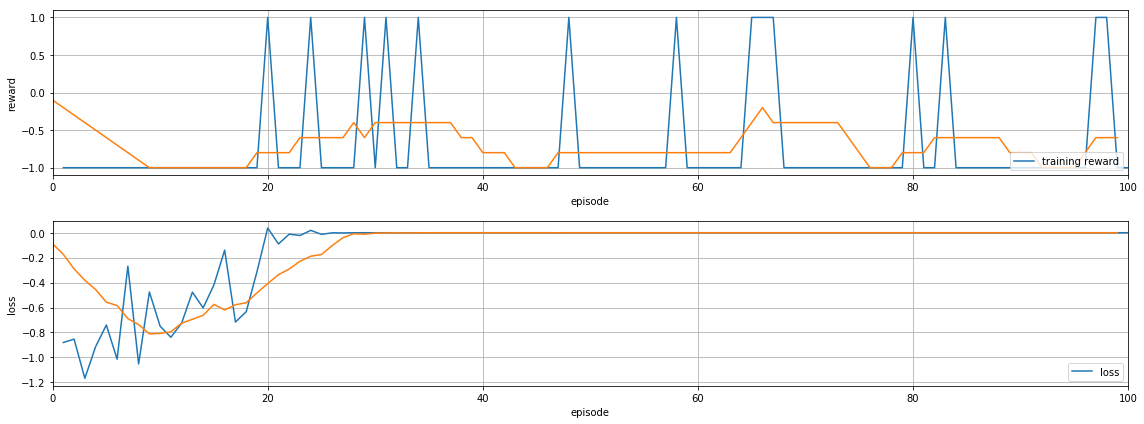

In [19]:
# plot results
import matplotlib.pyplot as plt

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()